In [19]:
# Data processing of the questionnaire
# https://forms.gle/TiY3p9WSkGV8mNKk6

# importing packages
import pandas as pd
#from SPARQLWrapper import SPARQLWrapper, JSON
#import lxml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#inNotebook = True # change this to True if you use a notebook
#def nextplot():
#    if inNotebook:
#        plt.figure()  # this creates a new plot
#    else:
#        plt.clf()     # and this clears the current one

!python --version
print('------------')
print("Pandas " + pd.__version__)
print("Numpy " + np.__version__)
print("Seaborn " + sns.__version__)

Python 3.7.6
------------
Pandas 1.3.4
Numpy 1.18.1
Seaborn 0.11.2


In [20]:
df = pd.read_csv('../data/Survey_data_14032022.csv')
df.head()

,Zeitstempel,Name up to three movies from the 90s,Name up to three actors,Name up to three music genres,Name up to three books,Name up to three (book) authors,Name up to three politicians,Name up to three US presidents,Name up to three cities,Name up to three lakes,...,Name up to three vegetables,Name up to three types of fast food,Name up to three landmarks/sights in Europe,Name up to three companies listed in the DAX (German stock index),Name up to three US companies,Name up to three US tech companies,What is your age?,What gender do you identify with?,What is the highest degree you have completed?,Which country are you from?
0,2022/02/28 4:09:27 PM MEZ,"The Matrix, Groundhog Day, Goodfellas","Tom Cruise, Amy Adams, Arnold Schwarzenegger","Pop, Techno, Rap","Dune, How Democracies Die, Harry Potter","Frank Herbert, George R. R. Martin, J. K. Rowl...","Barack Obama, Olaf Scholz, Robert Habeck","Barack Obama, Joe Biden, George Washington","Berlin, New York, Moskau","Bodensee, Lake Victoria, Lake Tahoe",...,"Peas, Carrot, Tomato","French Fries, Burger, Pizza","Eiffel tower, Brandenburger Gate, Colosseum","SAP, Allianz, Lufthansa","Microsoft, T-Mobile, Ralph Lauren","Apple, Google, Tesla",26.0,Male,Bachelor's degree,Germany
1,2022/03/01 4:03:02 PM MEZ,"Batman, Matrix, Eyes Wide Shut","Jack Nicholson, Nicole Kidman, George Clooney","Metal, Rock, Pop","Hamlet, Faust, Werther","Shakespeare, Goethe, Stephen King","Angela Merkel, Joe Biden, George W. Bush","Joe Biden, Goerge W. Bush, Barack Obama","New York, Amsterdam, Berlin","Lake Geneva, Lake Tahoe, Lake Eerie",...,"Cucumber, Tomato, Zucchini","Burger, Pizza, Fries","Eiffel Tower, Tower Bridge, Tower of Pisa","SAP, BMW, Siemens","Ford, General Electric, Meta","Meta, Alphabet, Zoom",44.0,Male,Doctorate (e.g. PhD),Germany
2,2022/03/01 4:34:10 PM MEZ,"Total Recall, Lethal Weapon, Predator","Gérard Depardieu, Christina Ricci, Brad Pitt","Funk, Rock, Electro","Hyperion, Harry Potter, Game of Thrones","Asimov, Herbert, Simmons","Jean-Luc Mélenchon, Raphaël Correa, Gabriel Boric","Georges Washington, Abraham Lincoln, Richard N...","Paris, New-York, Istanbul","Erie, Léman,",...,"Leek, Cabbage, Potato","Burger, Poutine, Hotdog","Eiffel Tower, Pisa Tower, Stonehenge","Bayer, BMW, Volkswagen","General Motors, General Electric, McDonals","Google, Amazon, Microsoft",46.0,Male,Bachelor's degree,France
3,2022/03/01 5:25:03 PM MEZ,"Léon: The Professional, The Matrix, Departed","Brad Pitt, Denzel Washington, George Clooney","Techno, House, Jazz","Illuminati, Das Kapital, The Prisoner","J. K. Rowling, John Grisham, Dan Brown","Robert Habeck, Olaf Scholz, Martin Schulz","Donald Trump, John F. Kennedy, Gerald Ford","Berlin, New York, Kyiv","Gardasee, Lake Michigan, Bodensee",...,"Zucchini, Aubergine, Peppers","Burger, Fries, Pizza","Eiffeltower, Brandenburg Gate, London Eye","Deutsche Lufthansa AG, Volkswagen AG, Freseniu...","Apple, Alphabet, Tesla Motors","Alphabet, Apple, Oracle",28.0,Male,Master's degree,Germany
4,2022/03/01 5:31:24 PM MEZ,"Home Alone, matrix, titanic","Nicole Kidman, Meryl Streep, Penelope Cruz","Jazz, pop, hip-hop","Idiot, Noisy Bear, Being and Time","Dostoevsky, Nabokov, Bradbury","Merkel, Obama, Biden","Obama, Biden, Lincoln","Leuven, Chisinau, Moscow","Geneva lake Baikal lake, Lugano Lake",...,"Bell pepper, aubergine, tomato","Fries, burger, nuggets","Eiffel Tower, Big Ben, Maneken Piss","Zalando, Volkswagen, Daimler","Walmart, Amazon, Apple","Tesla, Google, Microsoft",34.0,Female,Master's degree,Switzerland


In [21]:
# dictionary for renaming column names
# key = old name : value = new name
dictColNames = {'Zeitstempel':'timestamp',
        'Name up to three movies from the 90s': 'nineties_movies',
        'Name up to three actors': 'actors',
        'Name up to three music genres': 'music_genres',
        'Name up to three books':'books',
        'Name up to three (book) authors':'authors', #or book_authors?
        'Name up to three politicians':'politicians',
        'Name up to three US presidents':'us_presidents',
        'Name up to three cities':'cities',
        'Name up to three lakes':'lakes',
        'Name up to three mountains':'mountains',
        'Name up to three european capital cities':'european_capital_cities',
        'Name up to three european countries':'european_countries',
        'Name up to three asian countries':'asian_countries',
        'Name up to three continents':'continents',
        'Name up to three birds':'birds',
        'Name up to three african animals':'african_animals',
        'Name up to three pieces of furniture':'furniture',
        'Name up to three vegetables':'vegetables',
        'Name up to three types of fast food':'fast_food',
        'Name up to three landmarks/sights in Europe':'european_landmarks',
        'Name up to three companies listed in the DAX (German stock index)':'dax_companies',
        'Name up to three US companies':'us_companies',
        'Name up to three US tech companies':'us_tech_companies',
        'What is your age?':'p_age', # p for participant, partaker, player
        'What gender do you identify with?':'p_gender',
        'What is the highest degree you have completed?':'p_education',
        'Which country are you from?':'p_country'
        }

df.rename(columns=dictColNames, inplace=True)
df.head()

,timestamp,nineties_movies,actors,music_genres,books,authors,politicians,us_presidents,cities,lakes,...,vegetables,fast_food,european_landmarks,dax_companies,us_companies,us_tech_companies,p_age,p_gender,p_education,p_country
0,2022/02/28 4:09:27 PM MEZ,"The Matrix, Groundhog Day, Goodfellas","Tom Cruise, Amy Adams, Arnold Schwarzenegger","Pop, Techno, Rap","Dune, How Democracies Die, Harry Potter","Frank Herbert, George R. R. Martin, J. K. Rowl...","Barack Obama, Olaf Scholz, Robert Habeck","Barack Obama, Joe Biden, George Washington","Berlin, New York, Moskau","Bodensee, Lake Victoria, Lake Tahoe",...,"Peas, Carrot, Tomato","French Fries, Burger, Pizza","Eiffel tower, Brandenburger Gate, Colosseum","SAP, Allianz, Lufthansa","Microsoft, T-Mobile, Ralph Lauren","Apple, Google, Tesla",26.0,Male,Bachelor's degree,Germany
1,2022/03/01 4:03:02 PM MEZ,"Batman, Matrix, Eyes Wide Shut","Jack Nicholson, Nicole Kidman, George Clooney","Metal, Rock, Pop","Hamlet, Faust, Werther","Shakespeare, Goethe, Stephen King","Angela Merkel, Joe Biden, George W. Bush","Joe Biden, Goerge W. Bush, Barack Obama","New York, Amsterdam, Berlin","Lake Geneva, Lake Tahoe, Lake Eerie",...,"Cucumber, Tomato, Zucchini","Burger, Pizza, Fries","Eiffel Tower, Tower Bridge, Tower of Pisa","SAP, BMW, Siemens","Ford, General Electric, Meta","Meta, Alphabet, Zoom",44.0,Male,Doctorate (e.g. PhD),Germany
2,2022/03/01 4:34:10 PM MEZ,"Total Recall, Lethal Weapon, Predator","Gérard Depardieu, Christina Ricci, Brad Pitt","Funk, Rock, Electro","Hyperion, Harry Potter, Game of Thrones","Asimov, Herbert, Simmons","Jean-Luc Mélenchon, Raphaël Correa, Gabriel Boric","Georges Washington, Abraham Lincoln, Richard N...","Paris, New-York, Istanbul","Erie, Léman,",...,"Leek, Cabbage, Potato","Burger, Poutine, Hotdog","Eiffel Tower, Pisa Tower, Stonehenge","Bayer, BMW, Volkswagen","General Motors, General Electric, McDonals","Google, Amazon, Microsoft",46.0,Male,Bachelor's degree,France
3,2022/03/01 5:25:03 PM MEZ,"Léon: The Professional, The Matrix, Departed","Brad Pitt, Denzel Washington, George Clooney","Techno, House, Jazz","Illuminati, Das Kapital, The Prisoner","J. K. Rowling, John Grisham, Dan Brown","Robert Habeck, Olaf Scholz, Martin Schulz","Donald Trump, John F. Kennedy, Gerald Ford","Berlin, New York, Kyiv","Gardasee, Lake Michigan, Bodensee",...,"Zucchini, Aubergine, Peppers","Burger, Fries, Pizza","Eiffeltower, Brandenburg Gate, London Eye","Deutsche Lufthansa AG, Volkswagen AG, Freseniu...","Apple, Alphabet, Tesla Motors","Alphabet, Apple, Oracle",28.0,Male,Master's degree,Germany
4,2022/03/01 5:31:24 PM MEZ,"Home Alone, matrix, titanic","Nicole Kidman, Meryl Streep, Penelope Cruz","Jazz, pop, hip-hop","Idiot, Noisy Bear, Being and Time","Dostoevsky, Nabokov, Bradbury","Merkel, Obama, Biden","Obama, Biden, Lincoln","Leuven, Chisinau, Moscow","Geneva lake Baikal lake, Lugano Lake",...,"Bell pepper, aubergine, tomato","Fries, burger, nuggets","Eiffel Tower, Big Ben, Maneken Piss","Zalando, Volkswagen, Daimler","Walmart, Amazon, Apple","Tesla, Google, Microsoft",34.0,Female,Master's degree,Switzerland


In [46]:
# Replace NaN values for participants age with 0 and convert from float64 to int64
df.p_age = df.p_age.fillna(0)
df.p_age = df.p_age.astype(int)

# Replace NaN float values with String for the remaining entries
df = df.fillna('NaN')

#df.p_country = df.p_country.astype(str) #
df.p_country = df.p_country.str.lower()
df.p_country = [c.replace('united states of america', 'usa') for c in df.p_country]
df.p_country = [c.replace('deutschland', 'germany') for c in df.p_country]
df.p_country = [c.replace(' ', '') for c in df.p_country]

In [47]:
df.dtypes

timestamp                  object
nineties_movies            object
actors                     object
music_genres               object
books                      object
authors                    object
politicians                object
us_presidents              object
cities                     object
lakes                      object
mountains                  object
european_capital_cities    object
european_countries         object
asian_countries            object
continents                 object
birds                      object
african_animals            object
furniture                  object
vegetables                 object
fast_food                  object
european_landmarks         object
dax_companies              object
us_companies               object
us_tech_companies          object
p_age                       int64
p_gender                   object
p_education                object
p_country                  object
dtype: object

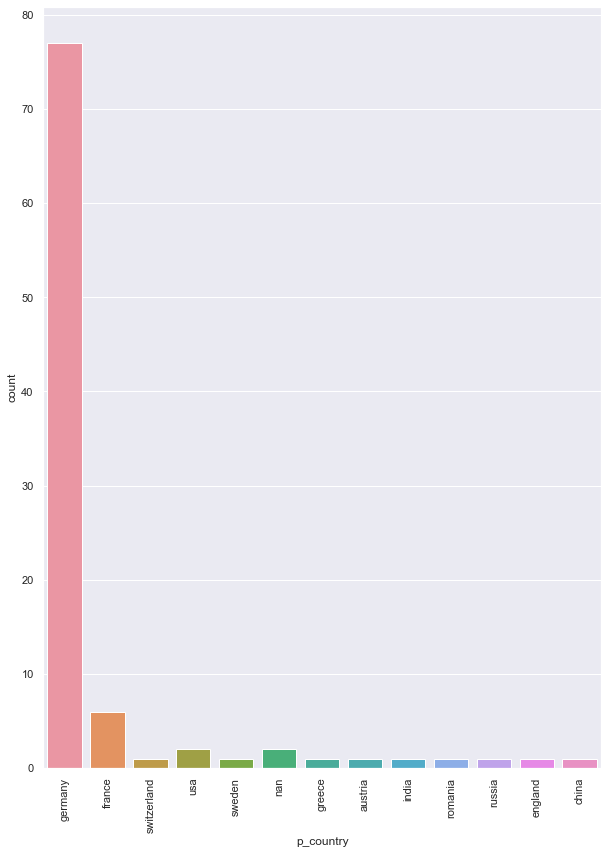

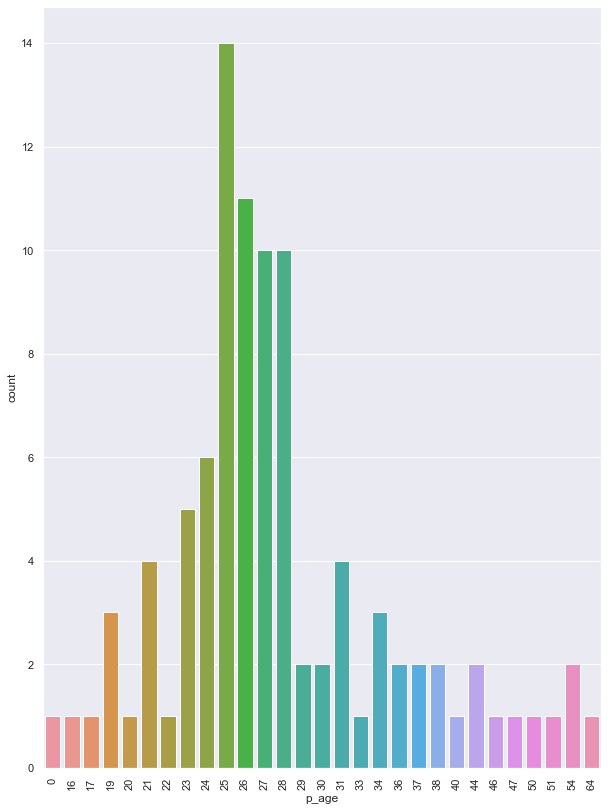

In [48]:
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="p_country", data=df)
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);
   
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="p_age", data=df)
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);

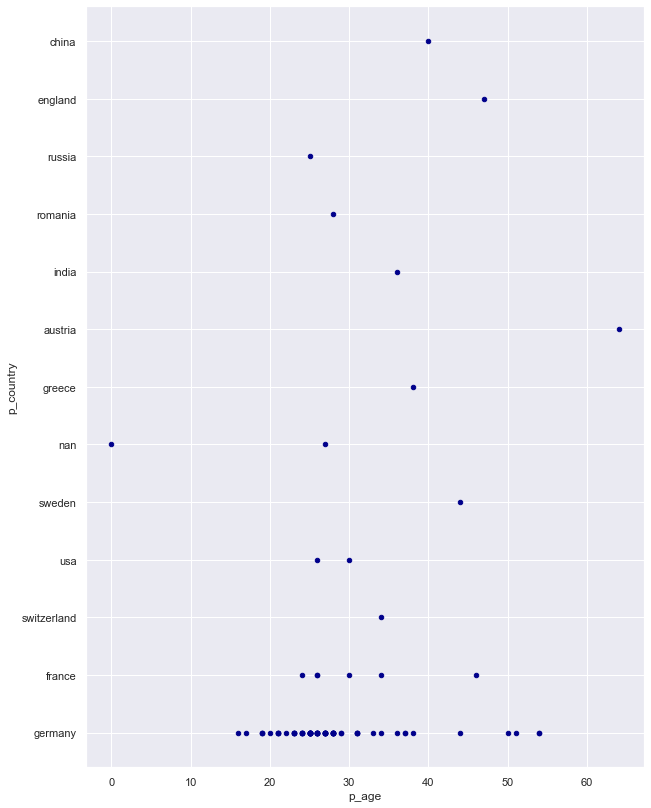

In [49]:
#df_age_dist = df[['p_age','p_country']].copy()
#df_age_dist.head()
df.plot.scatter(x='p_age', y='p_country', c='DarkBlue')

### Cleaning the categories

In [25]:
# function that takes a specific column out of the DataFrame, cleans it and returns it as a new DF
# needs DF column as dfColumnName and a string for the new DF column as cName

## TODO: Idea, rewrite function so that the demographic data is kept (sex, age, education, country, ...)
## But rows are split due to multiple answers. How can I avoid the loss of data?
## https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows

def oneColumnSplit(dfColumn, cName):
    helper_series = dfColumn
    helper_series = helper_series.str.lower()
    helper_series = [c.replace(';', ', ') for c in helper_series]
    helper_series = [c.replace('/', ', ') for c in helper_series]
    helper_series = [c.replace('?', ', ') for c in helper_series]
    helper_series = [c.replace("'", " ") for c in helper_series]
    helper_series = [c.replace('-', '') for c in helper_series]
    helper_series = [c.replace(' ', '') for c in helper_series]
    
    helper_series = [x.split(',') for x in helper_series]
    helper_list = [x for y in helper_series for x in y]
    helper_df = pd.DataFrame(helper_list)
    helper_df = helper_df.rename(columns={0: cName})

    return helper_df

In [26]:
df_nineties_movies = oneColumnSplit(df.nineties_movies, 'nineties_movies')
df_actors = oneColumnSplit(df.actors, 'actors')
df_music_genres = oneColumnSplit(df.music_genres, 'music_genres')
df_books = oneColumnSplit(df.books, 'books')
df_authors = oneColumnSplit(df.authors, 'authors')
df_politicians = oneColumnSplit(df.politicians, 'politicians')
df_us_presidents = oneColumnSplit(df.us_presidents, 'us_presidents')
df_cities = oneColumnSplit(df.cities, 'cities')
df_lakes = oneColumnSplit(df.lakes, 'lakes')
df_mountains = oneColumnSplit(df.mountains, 'mountains')
df_european_capital_cities = oneColumnSplit(df.european_capital_cities, 'european_capital_cities')
df_european_countries = oneColumnSplit(df.european_countries, 'european_countries')
df_asian_countries = oneColumnSplit(df.asian_countries, 'asian_countries')
df_continents = oneColumnSplit(df.continents, 'continents')
df_birds = oneColumnSplit(df.birds, 'birds')
df_african_animals = oneColumnSplit(df.african_animals, 'african_animals')
df_furniture = oneColumnSplit(df.furniture, 'furniture')
df_vegetables = oneColumnSplit(df.vegetables, 'vegetables')
df_fast_food = oneColumnSplit(df.fast_food, 'fast_food')
df_european_landmarks = oneColumnSplit(df.european_landmarks, 'european_landmarks')
df_dax_companies = oneColumnSplit(df.dax_companies, 'dax_companies')
df_us_companies = oneColumnSplit(df.us_companies, 'us_companies')
df_us_tech_companies = oneColumnSplit(df.us_tech_companies, 'us_tech_companies')
#p_age
#p_gender
#p_education
#p_country
            
print(df_nineties_movies)

       nineties_movies
0            thematrix
1         groundhogday
2           goodfellas
3               batman
4               matrix
..                 ...
234         meninblack
235   theusualsuspects
236  missionimpossible
237        harrypotter
238  thelordoftherings

[239 rows x 1 columns]


In [27]:
#df_musicGenres = df.copy()

#df_musicGenres.music_genres = [c.replace(';', ', ') for c in df.music_genres]
#df_musicGenres.music_genres = [c.replace('/', ', ') for c in df.music_genres]
#df_musicGenres.music_genres = [c.replace('?', ', ') for c in df.music_genres]
#df_musicGenres.music_genres = [c.replace("'", " ") for c in df.music_genres]
#df_musicGenres.music_genres = [c.replace('-', '') for c in df.music_genres]
#df_musicGenres.music_genres = [c.replace(' ', '') for c in df.music_genres]

# call function
#oneColumnSplit(df_musicGenres, 'music_genres')

#-------------------------
# https://www.kite.com/python/answers/how-to-make-a-pandas-dataframe-one-column-in-python
# https://stackoverflow.com/questions/23317342/pandas-dataframe-split-column-into-multiple-columns-right-align-inconsistent-c
#musicGenresList = []
#df_musicGenres.music_genres = df_musicGenres.music_genres.str.lower()

#df_musicGenres = df_musicGenres['music_genres'].apply(lambda x: pd.Series(x.split(',')))
#testsplit(df_musicGenres, 'music_genres')

#for column in df_musicGenres:
#    this_column_values = df_musicGenres[column].tolist()
#    musicGenresList += this_column_values

#df_musicGenres = pd.DataFrame(musicGenresList)
#df_musicGenres = df_musicGenres.rename(columns={0: 'music_genre'})
#-------------------------


#df_musicGenres.dtypes
#print(len(df_musicGenres.index))
#print(df_musicGenres)

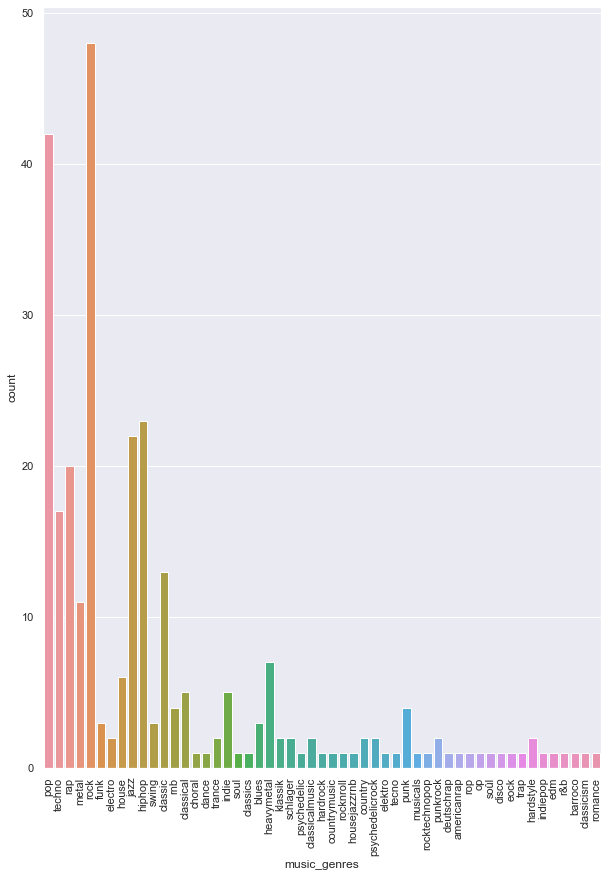

In [28]:
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='music_genres', data=df_music_genres)
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);

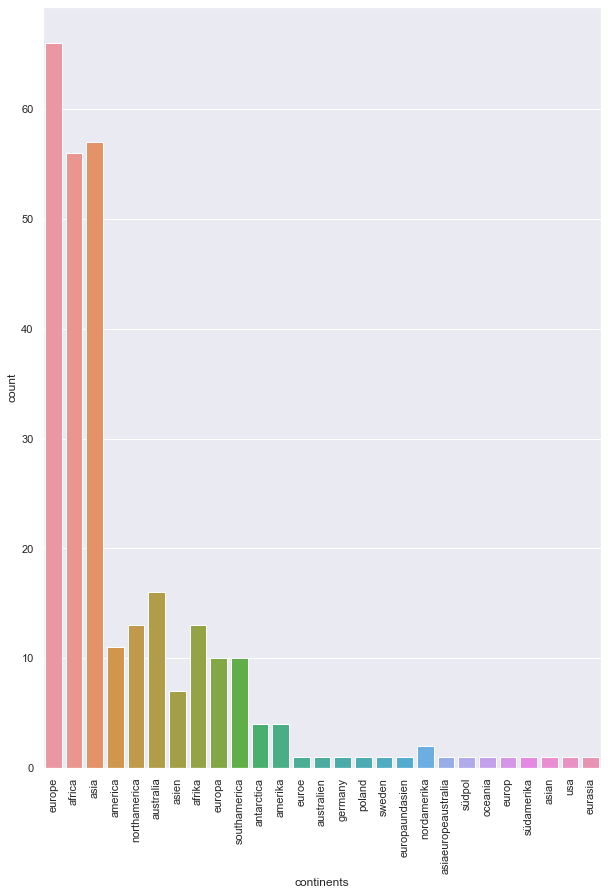

In [29]:
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='continents', data=df_continents)
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);

In [30]:
df_continents.head()
#sns.catplot(x="continents", data=df_continents)

,continents
0,europe
1,africa
2,asia
3,europe
4,africa
